In [1]:
"""
Nicolas Masse 2017
Contributions from Gregory Grant, Catherine Lee
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import matplotlib
# from tqdm.notebook import tqdm
from parameters_lif import par, update_dependencies

T           = par['T']    # total time to sumulate (msec)
dt          = par['simulation_dt'] # Simulation timestep
time        = par['time']
inpt        = par['inpt']   # Neuron input voltage
neuron_input= np.zeros(par["neuron_input"].shape)
neuron_input[500:2000] = 1.3 #par['neuron_input']

num_layers  = par['num_layers']
num_neurons = par['num_neurons']

--> Loading parameters...


In [2]:
# Graphing functions:
def plot_neuron_behaviour(time, data, neuron_type, neuron_id, y_title):
    # print ('Drawing graph with time.shape={}, data.shape={}'.format(time.shape, data.shape))
    plt.plot(time,data)
    plt.title('{0} @ {1}'.format(neuron_type, neuron_id))
    plt.ylabel(y_title)
    plt.xlabel('Time (msec)')

    # Graph to the data with some headroom
    y_min = min(data)*1.2
    y_max = max(data)*1.2
    if y_max == 0:
        y_max = 1
    plt.ylim([y_min,y_max])
    plt.show()

def plot_membrane_potential(time, V_m, neuron_type, neuron_id = 0):
    plot_neuron_behaviour(time, V_m, neuron_type, neuron_id, y_title = 'Membrane potential (V)')

def plot_spikes(time, V_m, neuron_type, neuron_id = 0):
    plot_neuron_behaviour(time, V_m, neuron_type, neuron_id, y_title = 'Spike (V)')

In [3]:
# Basic LIF Neuron class

class LIFNeuron():
    def __init__(self, debug=True, **specific_params):
        # Simulation config (may not all be needed!!)
        self.dt       = par['neuron_dt']       # neuronal time step
        self.t_rest   = par['t_rest']           # initial refractory time

        #LIF Properties
        self.exc      = np.zeros((4,1))  # Resting potential (mV?), threshold (mV?), refractory period (ms), gain (unitless)
        self.V_m      = np.zeros(1)    # Neuron potential (mV)
        self.time     = np.zeros(1)    # Time duration for the neuron (needed?)
        self.spikes   = np.zeros(1)    # Output (spikes) for the neuron

        self.gain     = par['gain']      # neuron gain (unitless)
        self.t        = par['t']         # Neuron time step
        self.Rm       = par['Rm']        # Resistance (kOhm)
        self.Cm       = par['Cm']        # Capacitance (uF)
        self.tau_m    = par['tau_m']     # Time constant (ms)
        self.tau_ref  = par['tau_ref']   # refractory period (ms)
        self.V_th     = par['V_th']      # = 1  #spike threshold
        self.V_spike  = par['V_spike']   # spike delta (V)
        self.V_rest   = specific_params.get("V_rest", par['V_rest'])    # resting potential (V)
        self.type     = par['type']
        self.debug    = par['debug']
        self.exc_func = specific_params.get("exc_func", par["exc_func"])
        if self.debug:
            print ('LIFNeuron(): Created {} neuron starting at time {}'.format(self.type, self.t))

    def spike_generator(self, neuron_input):
        # Create local arrays for this run
        duration = len(neuron_input)
        V_m = np.full(duration, self.V_rest) #len(time)) # potential (V) trace over time
        exc = np.full((4,duration), self.V_rest)
        exc[1, :] = self.V_th
        exc[2, :] = self.tau_ref
        exc[3, :] = self.gain
        time = np.arange(self.t, self.t+duration)
        spikes = np.zeros(duration)  #len(time))

        if self.debug:
            print ('spike_generator(): Running time period self.t={}, self.t+duration={}'
                   .format(self.t, self.t+duration))

        if self.debug:
            print ('LIFNeuron.spike_generator.initial_state(input={}, duration={}, initial V_m={}, t={})'
               .format(neuron_input, duration, V_m[-1], self.t))

        for i in range(duration):
            if self.debug:
                print ('Index {}'.format(i))

            if self.t > self.t_rest:

                V_m[i]=V_m[i-1] + (-V_m[i-1] + exc[0,i-1] + exc[3,i-1]*neuron_input[i-1]*self.Rm) / self.tau_m * self.dt
                exc[:, i] = self.exc_func(self.V_rest, self.V_th, self.tau_ref, self.gain,
                                          V_m[:i], spikes[:i], neuron_input[:i], exc[:,:i])
                if self.debug:
                    print('spike_generator(): i={}, self.t={}, V_m[i]={}, neuron_input={}, self.Rm={}, self.tau_m * self.dt = {}'
                          .format(i,self.t, V_m[i], neuron_input[i], self.Rm, self.tau_m * self.dt))

                if V_m[i] >= exc[1,i]:
                    spikes[i] += self.V_spike
                    self.t_rest = self.t + exc[2,i]
                    if self.debug:
                        print ('*** LIFNeuron.spike_generator.spike=(self.t_rest={}, self.t={}, self.tau_ref={})'
                           .format(self.t_rest, self.t, self.tau_ref))
            else:
                exc[:, i] = self.exc_func(self.V_rest, self.V_th, self.tau_ref, self.gain,
                                V_m[:i], spikes[:i], neuron_input[:i], exc[:,:i])
                V_m[i] = exc[0,i]

            self.t += self.dt

        # Save state
        # if the first time spikes are being generated
        if self.spikes.shape[0] == 1:
            self.spikes = spikes
            self.exc = exc
            self.V_m = V_m
            self.time = time
        else:
            self.exc = np.hstack((self.exc, exc))
            self.V_m = np.append(self.V_m, V_m)
            self.spikes = np.append(self.spikes, spikes)
            self.time = np.append(self.time, time)

        if self.debug:
            print ('LIFNeuron.spike_generator.exit_state(V_m={} at iteration i={}, time={})'
                   .format(self.V_m, i, self.t))

In [4]:
# define resting excitability function - params are V_rest, V_m, spikes, I, exc
def exc_func(V_rest, V_th, tau_ref, gain, V_m, spikes, I, exc):
    integrated_spikes = np.sum(spikes[-500:])
    integrated_current = np.sum(I[-500:])
    exc_rest = V_rest + integrated_spikes/10
    exc_thresh = V_th - integrated_current/2500
    exc_refrac = max(0.1, tau_ref - integrated_spikes*1.5)
    exc_gain = gain + integrated_spikes/2
    return V_rest, exc_thresh, tau_ref, exc_gain

In [5]:
# Create neuronal array
def create_neurons(num_layers, num_neurons, debug=False, **specific_params):
    neurons = []
    for layer in range(num_layers):
        if debug:
            print ('create_neurons(): Creating layer {}'.format(layer))
        neuron_layer = []
        for i in range(num_neurons):
            neuron_layer.append(LIFNeuron(debug=debug, **specific_params))
        neurons.append(neuron_layer)
    return neurons

neurons = create_neurons(num_layers, num_neurons, debug=False,
            V_rest=-.5, exc_func = exc_func)

for neuron in range(num_neurons):
    offset = random.randint(time/2, time/4)  # Simulates stimulus starting at different times
    stimulus = np.zeros_like(neuron_input)
    stimulus[offset:stimulus.shape[0]] = neuron_input[0:stimulus.shape[0] - offset]
    neurons[0][neuron].spike_generator(stimulus)

ValueError: empty range for randrange() (2000, 1001, -999)

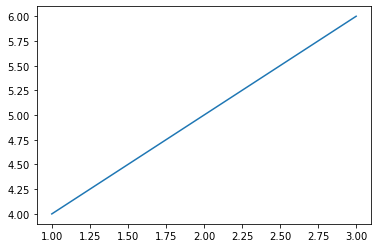

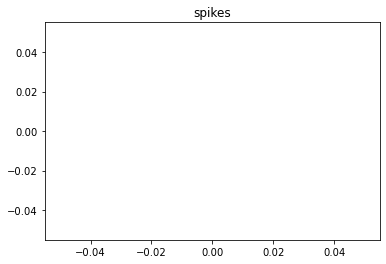

In [7]:
plt.plot([1,2,3], [4,5,6])
plt.show()
plt.plot(neurons[0][0].time, neurons[0][0].V_m)
plt.title("spikes")
plt.show()

In [ ]:
fig, axs = plt.subplots(num_layers)
# Simulate spike propagation through layers
for layer in np.arange(1,num_layers):
    layer_spikes = np.zeros_like(neurons[layer-1][0].spikes)
    for neuron in np.arange(num_neurons):
        layer_spikes += neurons[layer-1][neuron].spikes
    for neuron in np.arange(num_neurons):
        neurons[layer-1][neuron].spike_generator(layer_spikes)

    # Raster plots:

    axs[layer].eventplot(layer_spikes, orientation='horizontal', linelengths=1.5)

    plt.show()

plt.plot(layer_spikes)
plt.show()

# # Graph results
# plot_spikes(neurons[layer][0].time[start_time:end_time], layer_spikes[start_time:end_time],
# 'Input Spikes for {}'.format(neurons[layer][0].type), neuron_id = "{}/0".format(layer))
# plot_membrane_potential(neurons[layer][0].time[start_time:end_time], neurons[layer][0].V_m[start_time:end_time],
# 'Membrane Potential {}'.format(neurons[layer][0].type), neuron_id = "{}/0".format(layer))
# plot_spikes(neurons[layer][0].time[start_time:end_time], neurons[layer][0].spikes[start_time:end_time],
# 'Output spikes for {}'.format(neurons[layer][0].type), neuron_id = "{}/0".format(layer))
